In [1]:
from functools import partial
import json
import multiprocessing as mp
from pathlib import Path
import re
import sys
import time
from typing import Any

from google.cloud import storage
import numpy as np
import pandas as pd
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit import RDLogger
import vertexai
from vertexai.generative_models import GenerativeModel, GenerationConfig
from vertexai.tuning import sft

sys.path.insert(0, '../agenticadmet')
from eval import extract_preds, extract_refs, eval_admet
from utils import ECFP_from_smiles, tanimoto_similarity, standardize, standardize_cxsmiles

[02:18:54] Initializing Normalizer


In [2]:
logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL)

In [3]:
PROJECT_ID = "bioptic-io"
LOCATION = "us-central1"
vertexai.init(project=PROJECT_ID, location=LOCATION)

RANDOM_SEED = 42
SPLIT = 0

In [4]:
PROPERTY = 'LogD'
TRAIN_HYPOTHESES = [
    # 'top_with_given_property',
    # 'rdkit_descriptors',
    # 'smiles_only'
]
VAL_HYPOTHESES = [
    'top_with_given_property',
    # 'top_with_given_property_no_finetune',
    # 'rdkit_descriptors',
    # 'rdkit_descriptors_no_finetune',
    # 'smiles_only'
]

In [5]:
data = pd.read_csv(f'../data/asap/datasets/rnd_splits/split_{SPLIT}.csv')
data

,smiles,HLM,KSOL,LogD,MLM,MDR1-MDCKII,smiles_std,cxsmiles_std,mol_idx,smiles_ext,LogHLM,LogMLM,LogKSOL,LogMDR1-MDCKII,split
0,COC1=CC=CC(Cl)=C1NC(=O)N1CCC[C@H](C(N)=O)C1 |a...,NaN,NaN,0.3,NaN,2.0,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1 |a:16|,191,|a:16|,NaN,NaN,NaN,0.477121,val
1,O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...,NaN,333.0,2.9,NaN,0.2,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,335,|&1:7|,NaN,NaN,2.523746,0.079181,train
2,O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Br)=...,NaN,NaN,0.4,NaN,0.5,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,336,|&1:7|,NaN,NaN,NaN,0.176091,train
3,NC(=O)[C@H]1CCCN(C(=O)CC2=CC=CC3=C2C=CO3)C1 |&...,NaN,376.0,1.0,NaN,8.5,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1 |&1:3|,300,|&1:3|,NaN,NaN,2.576341,0.977724,train
4,CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|,NaN,375.0,-0.3,NaN,0.9,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1 |&1:11|,249,|&1:11|,NaN,NaN,2.575188,0.278754,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,CC(C)NC[C@H](O)COC1=CC=CC2=CC=CC=C12 |&1:5|,25.5,NaN,NaN,63.0,NaN,CC(C)NC[C@H](O)COc1cccc2ccccc12,CC(C)NC[C@H](O)COc1cccc2ccccc12 |&1:5|,22,|&1:5|,1.423246,1.806180,NaN,NaN,val
430,O=C(O)CC1=CC=CC=C1NC1=C(Cl)C=CC=C1Cl,216.0,NaN,NaN,386.0,NaN,O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl,O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl,380,NaN,2.336460,2.587711,NaN,NaN,val
431,NCC1=CC(Cl)=CC(C(=O)NC2=CC=C3CNCC3=C2)=C1,NaN,NaN,2.0,NaN,NaN,NCc1cc(Cl)cc(C(=O)Nc2ccc3c(c2)CNC3)c1,NCc1cc(Cl)cc(C(=O)Nc2ccc3c(c2)CNC3)c1,303,NaN,NaN,NaN,NaN,NaN,train
432,COC(=O)NC1=NC2=CC=C(C(=O)C3=CC=CC=C3)C=C2N1,NaN,NaN,2.9,NaN,NaN,COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1,COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1,166,NaN,NaN,NaN,NaN,NaN,train


In [6]:
def save_and_upload_training_data(data, path, gs_uri):
    with open(path, 'w') as f:
        for item in data:
            f.write(json.dumps(item) + '\n')

    storage_client = storage.Client()
    bucket_name, key = gs_uri[5:].split("/", 1)
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(key)
    blob.upload_from_filename(path)

In [7]:
def start_finetuning_sft(
        train_dataset_gs_uri: str, source_model: str = "gemini-1.5-pro-002",
        adapter_size: int = 4, epochs: int = 10
    ):
    sft_tuning_job = sft.train(
        source_model=source_model,
        train_dataset=train_dataset_gs_uri,
        adapter_size=adapter_size,
        epochs=epochs
    )

    print(sft_tuning_job.tuned_model_name)
    print(sft_tuning_job.tuned_model_endpoint_name)

In [8]:
def get_answer(model, content):
    result = model.generate_content(content['contents'])
    answer = result.candidates[0].content.parts[0].text
    try:
        answer = float(re.search(r'Answer: (-?\d+\.\d+)', answer.strip()).group(1))
    except Exception as e:
        print(answer)
        return None
    
    return answer

## Hypothesis 1 - top-k closest molecules from train with given properties

In [9]:
TOPK = 5

In [10]:
train = data[data['split'] == 'train'].reset_index(drop=True)
val = data[data['split'] == 'val'].reset_index(drop=True)
ref_data = data[(data['split'] == 'train') & ~data[PROPERTY].isna()].reset_index(drop=True)
train_ecfp = np.array(train['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
val_ecfp = np.array(val['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
ref_ecfp = np.array(ref_data['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
train2ref_dist = tanimoto_similarity(train_ecfp, ref_ecfp)
val2ref_dist = tanimoto_similarity(val_ecfp, ref_ecfp)
train2ref_dist.shape, val2ref_dist.shape

((347, 277), (87, 277))

In [11]:
ref_data

,smiles,HLM,KSOL,LogD,MLM,MDR1-MDCKII,smiles_std,cxsmiles_std,mol_idx,smiles_ext,LogHLM,LogMLM,LogKSOL,LogMDR1-MDCKII,split
0,O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...,NaN,333.0,2.90,NaN,0.2,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,335,|&1:7|,NaN,NaN,2.523746,0.079181,train
1,O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Br)=...,NaN,NaN,0.40,NaN,0.5,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,336,|&1:7|,NaN,NaN,NaN,0.176091,train
2,NC(=O)[C@H]1CCCN(C(=O)CC2=CC=CC3=C2C=CO3)C1 |&...,NaN,376.0,1.00,NaN,8.5,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1 |&1:3|,300,|&1:3|,NaN,NaN,2.576341,0.977724,train
3,CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|,NaN,375.0,-0.30,NaN,0.9,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1 |&1:11|,249,|&1:11|,NaN,NaN,2.575188,0.278754,train
4,O=C(NCC(F)F)[C@H](NC1=CN=C2CNCC2=C1)C1=CC(Cl)=...,NaN,362.0,1.50,NaN,0.8,O=C(NCC(F)F)[C@H](Nc1cnc2c(c1)CNC2)c1cc(Cl)cc(...,O=C(NCC(F)F)[C@H](Nc1cnc2c(c1)CNC2)c1cc(Cl)cc(...,341,|&1:7|,NaN,NaN,2.559907,0.255273,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...,1.0,NaN,1.07,23.0,1.7,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,112,NaN,0.301030,1.380211,NaN,0.431364,train
273,O=C(O)C[C@H](NC(=O)C1=NC=NC2=C1C=CN2)C1=CC=C(B...,6.0,NaN,0.22,1.0,2.6,O=C(O)C[C@H](NC(=O)c1ncnc2[nH]ccc12)c1ccc(Br)cc1,O=C(O)C[C@H](NC(=O)c1ncnc2[nH]ccc12)c1ccc(Br)c...,379,|&1:4|,0.845098,0.301030,NaN,0.556303,train
274,O=C(NC1=CC=CC=C1)NC1=CC=C(C(=O)NC2C3=C(CC2C(=O...,9.0,319.0,0.12,2.0,0.7,O=C(Nc1ccccc1)Nc1ccc(C(=O)NC2c3cccc(O)c3CC2C(=...,O=C(Nc1ccccc1)Nc1ccc(C(=O)NC2c3cccc(O)c3CC2C(=...,377,NaN,1.000000,0.477121,2.505150,0.230449,train
275,NCC1=CC(Cl)=CC(C(=O)NC2=CC=C3CNCC3=C2)=C1,NaN,NaN,2.00,NaN,NaN,NCc1cc(Cl)cc(C(=O)Nc2ccc3c(c2)CNC3)c1,NCc1cc(Cl)cc(C(=O)Nc2ccc3c(c2)CNC3)c1,303,NaN,NaN,NaN,NaN,NaN,train


In [ ]:
data

,smiles,HLM,KSOL,LogD,MLM,MDR1-MDCKII,smiles_std,cxsmiles_std,mol_idx,smiles_ext,LogHLM,LogMLM,LogKSOL,LogMDR1-MDCKII,split
0,COC1=CC=CC(Cl)=C1NC(=O)N1CCC[C@H](C(N)=O)C1 |a...,NaN,NaN,0.3,NaN,2.0,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1 |a:16|,191,|a:16|,NaN,NaN,NaN,0.477121,val
1,O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...,NaN,333.0,2.9,NaN,0.2,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,335,|&1:7|,NaN,NaN,2.523746,0.079181,train
2,O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Br)=...,NaN,NaN,0.4,NaN,0.5,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,336,|&1:7|,NaN,NaN,NaN,0.176091,train
3,NC(=O)[C@H]1CCCN(C(=O)CC2=CC=CC3=C2C=CO3)C1 |&...,NaN,376.0,1.0,NaN,8.5,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1 |&1:3|,300,|&1:3|,NaN,NaN,2.576341,0.977724,train
4,CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|,NaN,375.0,-0.3,NaN,0.9,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1 |&1:11|,249,|&1:11|,NaN,NaN,2.575188,0.278754,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,CC(C)NC[C@H](O)COC1=CC=CC2=CC=CC=C12 |&1:5|,25.5,NaN,NaN,63.0,NaN,CC(C)NC[C@H](O)COc1cccc2ccccc12,CC(C)NC[C@H](O)COc1cccc2ccccc12 |&1:5|,22,|&1:5|,1.423246,1.806180,NaN,NaN,val
430,O=C(O)CC1=CC=CC=C1NC1=C(Cl)C=CC=C1Cl,216.0,NaN,NaN,386.0,NaN,O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl,O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl,380,NaN,2.336460,2.587711,NaN,NaN,val
431,NCC1=CC(Cl)=CC(C(=O)NC2=CC=C3CNCC3=C2)=C1,NaN,NaN,2.0,NaN,NaN,NCc1cc(Cl)cc(C(=O)Nc2ccc3c(c2)CNC3)c1,NCc1cc(Cl)cc(C(=O)Nc2ccc3c(c2)CNC3)c1,303,NaN,NaN,NaN,NaN,NaN,train
432,COC(=O)NC1=NC2=CC=C(C(=O)C3=CC=CC=C3)C=C2N1,NaN,NaN,2.9,NaN,NaN,COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1,COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1,166,NaN,NaN,NaN,NaN,NaN,train


In [13]:
def get_all_topk_smiles_with_properties(ref_data, query_data, query2ref_dist, topk=TOPK, property=PROPERTY):
    for i in range(query2ref_dist.shape[0]):
        query_smiles = query_data.iloc[i]['cxsmiles_std']
        query_property = query_data.iloc[i][property]
        if np.isnan(query_property):
            continue

        dist = query2ref_dist[i]
        order = np.argsort(dist)[::-1]
        ordered_dist = dist[order]
        order = order[~np.isclose(ordered_dist, 1.0)]  # remove self-similarity including duplicates
        topk_idx = order[:topk]
        topk_smiles = ref_data.iloc[topk_idx]['cxsmiles_std'].tolist()
        topk_properties = ref_data.iloc[topk_idx][property].tolist()
        yield topk_smiles, topk_properties, query_smiles, query_property

In [14]:
def format_data(
    input_smiles: list[str],
    input_properties: list[float],
    query_smiles: str,
    query_property: float | None = None,
    system_instruction: str | None = None
):
    if system_instruction is not None:
        output = {
            "systemInstruction": {
            "role": "Ignored",
            "parts": [
            {
                "text": system_instruction
            }
            ]
        }
    }
    else:
        output = {}
    
    output.update({
        "contents": [
            {
            "role": "user",
            "parts": [
                {
                    "text": f"SMILES: {smi}, {PROPERTY}: {prop:.2f}",
                }
                for smi, prop in zip(input_smiles, input_properties)
            ] + [
                {
                    "text": f"Determine {PROPERTY} of {query_smiles}"
                }
            ]
            }
        ]
    })

    if query_property is not None:
        output['contents'].append({
            "role": "model",
            "parts": [
                {
                    "text": f"Answer: {query_property:.2f}"
                }
            ]
        })
    
    return output

In [15]:
SYSTEM_INSTRUCTIONS = {
    "LogD": \
        "You are an experienced medicinal chemist who worked many years with solubility testing of compounds. "
        "You can determine the LogD of a molecule based on its structure and properties of similar molecules from a reference set. "
        "You are given a list of ten reference molecules represented in SMILES paired with their LogD values. "
        "Some values might be incorrect due to assay errors. If you see extended notation like |&1:3|, "
        "it means that the molecule has mixed stereochemistry. If you see notation like |o1:4|, it means "
        "that the molecule has undefined stereochemistry (either R or S isomer). Take these compounds with care. "
        "Your task is to determine the LogD at pH 7.4 of the molecule represented in SMILES. "
        "Answer only with a single floating point number in the \"Answer: number\" format, e.g. \"Answer: 2.7\". "
        "Don't describe your solution and don't put any other text in your answer."
}

In [16]:
train_dataset = [
    format_data(
        input_smiles=input_smiles,
        input_properties=input_properties,
        query_smiles=query_smiles,
        query_property=query_property,
        system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY]
    )
    for input_smiles, input_properties, query_smiles, query_property in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=train,
        query2ref_dist=train2ref_dist,
        topk=TOPK,
        property=PROPERTY
    )
]

In [17]:
val_dataset = [
    format_data(
        input_smiles=input_smiles,
        input_properties=input_properties,
        query_smiles=query_smiles,
    )
    for input_smiles, input_properties, query_smiles, _ in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=val,
        query2ref_dist=val2ref_dist,
        topk=TOPK,
        property=PROPERTY
    )
]

In [18]:
train_dataset[0]

{'systemInstruction': {'role': 'Ignored',
  'parts': [{'text': 'You are an experienced medicinal chemist who worked many years with solubility testing of compounds. You can determine the LogD of a molecule based on its structure and properties of similar molecules from a reference set. You are given a list of ten reference molecules represented in SMILES paired with their LogD values. Some values might be incorrect due to assay errors. If you see extended notation like |&1:3|, it means that the molecule has mixed stereochemistry. If you see notation like |o1:4|, it means that the molecule has undefined stereochemistry (either R or S isomer). Take these compounds with care. Your task is to determine the LogD at pH 7.4 of the molecule represented in SMILES. Answer only with a single floating point number in the "Answer: number" format, e.g. "Answer: 2.7". Don\'t describe your solution and don\'t put any other text in your answer.'}]},
 'contents': [{'role': 'user',
   'parts': [{'text': 

In [19]:
train_smi = [
    datum['contents'][0]['parts'][i]['text'][8:].split(',')[0]
    for i in range(TOPK) for datum in train_dataset
]
train_smi[:10]

['O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc(C2CC2)c1 |&1:7|',
 'O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc2c1CCC2 |&1:7|',
 'Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1 |&1:11|',
 'NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1 |&1:3|',
 'O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc(C2CC2)c1 |&1:7|',
 'COCc1cc(Cl)cc([C@H](Nc2ccc3c(c2)CNC3)C(=O)NCC(F)F)c1 |&1:9|',
 'COCc1cc(Cl)cc([C@H](Nc2ccc3c(c2)CNC3)C(=O)NCC(F)F)c1 |&1:9|',
 'O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc2c1CCC2 |&1:7|',
 'O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc(C2CC2)c1 |&1:7|',
 'COc1cc(Cl)cc([C@H](Nc2ccc3c(c2)CNC3)C(=O)NCC(F)F)c1 |&1:8|']

In [20]:
n_duplicates = 0
for smi in val['cxsmiles_std']:
    if smi in train_smi:
        n_duplicates += 1
n_duplicates

8

### Dry test - what if taking average LogD of top-k molecules does the job already?

In [21]:
val_tmp = val.copy()
pred_tmp = [
    np.mean(topk_properties)
    for topk_smiles, topk_properties, query_smiles, query_property in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=val,
        query2ref_dist=val2ref_dist,
        topk=TOPK,
        property=PROPERTY
    )
]
val_tmp.loc[val_tmp['LogD'].notna(), 'pred_LogD'] = pred_tmp
val_preds = extract_preds(val_tmp, target_columns=[PROPERTY])
val_refs = extract_refs(val_tmp, target_columns=[PROPERTY])
metrics = eval_admet(val_preds, val_refs, target_columns=[PROPERTY])
print(json.dumps(metrics, indent=2))

{
  "LogD": {
    "mean_absolute_error": 0.5774925373134329,
    "r2": 0.5182814794406733
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.5774925373134329,
    "macro_r2": 0.5182814794406733
  }
}


In [22]:
data_path = Path(f"../data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_train.jsonl")
data_path.parent.mkdir(parents=True, exist_ok=True)
gs_uri = f"<gs_bucket>/data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_train.jsonl"

save_and_upload_training_data(train_dataset, data_path, gs_uri)

In [23]:
if 'top_with_given_property' in TRAIN_HYPOTHESES:
    start_finetuning_sft(train_dataset_gs_uri=gs_uri, epochs=10)

In [24]:
if 'top_with_given_property' in VAL_HYPOTHESES:
    # TUNING_JOB_ID = "3011225915100233728"   # gemini-1.5-pro-002 epochs=10, top-k=3
    TUNING_JOB_ID = "7484694525823156224"   # gemini-1.5-pro-002 epochs=10, top-k=5, MAE=0.35
    # TUNING_JOB_ID = "8143205233837735936"   # gemini-1.5-pro-002 epochs=30, top-k=5, MAE=0.47
    # TUNING_JOB_ID = "6480462177663713280"   # gemini-1.5-pro-002 epochs=10, top-k=50
    # TUNING_JOB_ID = "4625981885791600640"   # gemini-1.5-pro-002 epochs=30
    # TUNING_JOB_ID = "9170184278552608768"   # gemini-1.5-pro-002 epochs=10
    # TUNING_JOB_ID = "4485736978645516288" # gemini-1.5-flash-001 epochs=10
    sft_tuning_job = sft.SupervisedTuningJob(f"projects/{PROJECT_ID}/locations/{LOCATION}/tuningJobs/{TUNING_JOB_ID}")
    tuned_model = GenerativeModel(
        sft_tuning_job.tuned_model_endpoint_name,
        system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY],
        generation_config=GenerationConfig(
            temperature=0.0,
        )
    )

In [25]:
if 'top_with_given_property' in VAL_HYPOTHESES:
    for content in val_dataset:
        result = tuned_model.generate_content(content['contents'])
        print(result)
        break

candidates {
  content {
    role: "model"
    parts {
      text: "Answer: 0.60\n\n"
    }
  }
  finish_reason: STOP
  avg_logprobs: -0.34556913375854492
}
usage_metadata {
  prompt_token_count: 463
  candidates_token_count: 8
  total_token_count: 471
  prompt_tokens_details {
    modality: TEXT
    token_count: 463
  }
  candidates_tokens_details {
    modality: TEXT
    token_count: 8
  }
}
create_time {
  seconds: 1741400336
  nanos: 243349000
}
response_id: "EKnLZ5XtDpX2ld8PqLnI-Qs"



In [26]:
save_path = Path(f"../output/asap/rnd_splits/gemini/run_0/split_{SPLIT}/val_predictions.csv")

In [27]:
if 'top_with_given_property' in VAL_HYPOTHESES:
    predictions = list(tqdm(map(partial(get_answer, tuned_model), val_dataset), total=len(val_dataset)))
    val.loc[val[PROPERTY].notna(), f'pred_{PROPERTY}'] = predictions
    save_path.parent.mkdir(parents=True, exist_ok=True)
    val.to_csv(save_path, index=False)

100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


In [28]:
val = pd.read_csv(save_path)
val_preds = extract_preds(val, target_columns=[PROPERTY])
val_refs = extract_refs(val, target_columns=[PROPERTY])
metrics = eval_admet(val_preds, val_refs, target_columns=[PROPERTY])
print(json.dumps(metrics, indent=2))

{
  "LogD": {
    "mean_absolute_error": 0.35880597014925375,
    "r2": 0.8128337182287024
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.35880597014925375,
    "macro_r2": 0.8128337182287024
  }
}


## Hypothesis 2 - top-k closest molecules from train with given properties (no fine-tune)

In [29]:
if 'top_with_given_property_no_finetune' in VAL_HYPOTHESES:
    model = GenerativeModel(
        "gemini-1.5-pro-002",
        system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY],
        generation_config=GenerationConfig(
            temperature=0.0
        )
    )

In [30]:
save_path = Path(f"../output/asap/rnd_splits/gemini/run_1/split_{SPLIT}/val_predictions.csv")

In [31]:
if 'top_with_given_property_no_finetune' in VAL_HYPOTHESES:
    predictions = list(tqdm(map(partial(get_answer, model), val_dataset), total=len(val_dataset)))
    val.loc[val[PROPERTY].notna(), f'pred_{PROPERTY}'] = predictions
    save_path.parent.mkdir(parents=True, exist_ok=True)
    val.to_csv(save_path, index=False)

In [32]:
val = pd.read_csv(save_path)
val_preds = extract_preds(val, target_columns=[PROPERTY])
val_refs = extract_refs(val, target_columns=[PROPERTY])
metrics = eval_admet(val_preds, val_refs, target_columns=[PROPERTY])
print(json.dumps(metrics, indent=2))

{
  "LogD": {
    "mean_absolute_error": 0.5304477611940297,
    "r2": 0.6273667699465235
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.5304477611940297,
    "macro_r2": 0.6273667699465235
  }
}


## Hypothesis 3 - RDKit descriptors

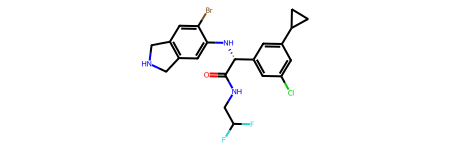

In [33]:
smiles = train.iloc[0]['smiles_std']
mol = Chem.MolFromSmiles(smiles)
mol

In [34]:
def extract_properties_v2(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return {"error": "Invalid SMILES string."}
    
    properties = {}

    # --- Basic RDKit Descriptors ---
    properties["molecular_weight"] = Descriptors.MolWt(mol)
    properties["num_rotatable_bonds"] = Descriptors.NumRotatableBonds(mol)
    properties["TPSA"] = rdMolDescriptors.CalcTPSA(mol)
    properties["H_bond_donors"] = Descriptors.NumHDonors(mol)
    properties["H_bond_acceptors"] = Descriptors.NumHAcceptors(mol)
    properties["Wildman_Crippen_LogP"] = Descriptors.MolLogP(mol)
    
    # --- Ring Counts ---
    properties["num_aromatic_rings"] = rdMolDescriptors.CalcNumAromaticRings(mol)
    properties["num_aliphatic_rings"] = rdMolDescriptors.CalcNumAliphaticRings(mol)
    
    # --- Functional Groups via SMARTS ---
    carboxylic_acid_smarts = Chem.MolFromSmarts('C(=O)[OH]')
    properties["carboxylic_acids"] = len(mol.GetSubstructMatches(carboxylic_acid_smarts))
    
    boronic_acid_smarts = Chem.MolFromSmarts('B(O)O')
    properties["boronic_acids"] = len(mol.GetSubstructMatches(boronic_acid_smarts))
    
    amide_smarts = Chem.MolFromSmarts('C(=O)N')
    properties["amide_groups"] = len(mol.GetSubstructMatches(amide_smarts))
    
    quaternary_ammonium_smarts = Chem.MolFromSmarts('[N+](C)(C)(C)C')
    properties["quaternary_amines"] = len(mol.GetSubstructMatches(quaternary_ammonium_smarts))
    
    sulfonic_acid_smarts = Chem.MolFromSmarts('S(=O)(=O)[OH]')
    properties["sulfonic_acids"] = len(mol.GetSubstructMatches(sulfonic_acid_smarts))
    
    amine_smarts = Chem.MolFromSmarts('[NX3;H2,H1]')
    properties["primary_secondary_amines"] = len(mol.GetSubstructMatches(amine_smarts))
    
    hydroxyl_smarts = Chem.MolFromSmarts('[OX2H]')
    properties["hydroxyl_groups"] = len(mol.GetSubstructMatches(hydroxyl_smarts))
    
    ether_smarts = Chem.MolFromSmarts('[OX2]C')
    properties["ethers"] = len(mol.GetSubstructMatches(ether_smarts))
    
    halogen_smarts = Chem.MolFromSmarts('[F,Cl,Br,I]')
    properties["halogens"] = len(mol.GetSubstructMatches(halogen_smarts))
    
    trifluoromethyl_smarts = Chem.MolFromSmarts('[CX3](F)(F)F')
    properties["trifluoromethyl"] = len(mol.GetSubstructMatches(trifluoromethyl_smarts))
    
    thioether_smarts = Chem.MolFromSmarts('[#6][S][#6]')
    properties["thioethers"] = len(mol.GetSubstructMatches(thioether_smarts))
    
    sulfone_smarts = Chem.MolFromSmarts('S(=O)(=O)')
    properties["sulfones_sulfoxides"] = len(mol.GetSubstructMatches(sulfone_smarts))
    
    carbonyl_smarts = Chem.MolFromSmarts('[CX3]=O')
    properties["carbonyls"] = len(mol.GetSubstructMatches(carbonyl_smarts))
    
    ester_smarts = Chem.MolFromSmarts('C(=O)O')
    properties["esters"] = len(mol.GetSubstructMatches(ester_smarts))

    properties["LogP"] = Descriptors.MolLogP(mol)
    
    # --- Additional Descriptors for LogD Prediction ---
    properties["FractionCSP3"] = rdMolDescriptors.CalcFractionCSP3(mol)
    properties["MolMR"] = Descriptors.MolMR(mol)
    properties["Chi0"] = Descriptors.Chi0(mol)
    properties["Chi1"] = Descriptors.Chi1(mol)
    properties["Kappa1"] = Descriptors.Kappa1(mol)
    properties["Kappa2"] = Descriptors.Kappa2(mol)
    properties["Kappa3"] = Descriptors.Kappa3(mol)
    properties["BertzCT"] = Descriptors.BertzCT(mol)
    properties["Ipc"] = Descriptors.Ipc(mol)
    
    # --- Extended Connectivity Fingerprint (Morgan FP) ---
    ## fp = Chem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
    ## fp_array = np.zeros((1024,), dtype=int)
    ## DataStructs.ConvertToNumpyArray(fp, fp_array)
    ## properties["morgan_fp"] = fp_array.tolist()
    ## fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
    ## fp_array = np.zeros((1024,), dtype=int)
    ## DataStructs.ConvertToNumpyArray(fp, fp_array)
    ## properties["morgan_fp"] = fp_array.tolist()
    
    # generator = rdMolDescriptors.MorganGenerator(radius=2, fpSize=1024)
    # fp = generator.GetFingerprint(mol)
    # fp_array = np.zeros((1024,), dtype=int)
    # DataStructs.ConvertToNumpyArray(fp, fp_array)
    # properties["morgan_fp"] = fp_array.tolist()

    return properties

In [35]:
extract_properties_v2(smiles)

{'molecular_weight': 484.7720000000002,
 'num_rotatable_bonds': 7,
 'TPSA': 53.160000000000004,
 'H_bond_donors': 3,
 'H_bond_acceptors': 3,
 'Wildman_Crippen_LogP': 5.117600000000003,
 'num_aromatic_rings': 2,
 'num_aliphatic_rings': 2,
 'carboxylic_acids': 0,
 'boronic_acids': 0,
 'amide_groups': 1,
 'quaternary_amines': 0,
 'sulfonic_acids': 0,
 'primary_secondary_amines': 3,
 'hydroxyl_groups': 0,
 'ethers': 0,
 'halogens': 4,
 'trifluoromethyl': 0,
 'thioethers': 0,
 'sulfones_sulfoxides': 0,
 'carbonyls': 1,
 'esters': 0,
 'LogP': 5.117600000000003,
 'FractionCSP3': 0.38095238095238093,
 'MolMR': 113.4901,
 'Chi0': 20.543241116511002,
 'Chi1': 13.901887240964333,
 'Kappa1': 20.567849557232954,
 'Kappa2': 8.5780651111598,
 'Kappa3': 4.89949711170493,
 'BertzCT': 936.382492308937,
 'Ipc': 5535452.576047839}

In [36]:
def get_rdkit_descriptors(data) -> list[dict[str, Any]]:
    all_descriptors = []
    for i in range(data.shape[0]):
        smiles = data.iloc[i]['cxsmiles_std']
        descriptors = extract_properties_v2(smiles)
        all_descriptors.append(descriptors)
    
    return all_descriptors

In [37]:
SYSTEM_INSTRUCTIONS = {
    "LogD": \
        "You are an experienced medicinal chemist who worked many years with solubility testing of compounds. "
        "You can determine the LogD of a molecule based on its structure and calculated molecular properties. "
        "You are given a list of ten reference molecules represented in SMILES paired with their LogD values. "
        "Some values might be incorrect due to assay errors. If you see extended notation like |&1:3|, "
        "it means that the molecule has mixed stereochemistry. If you see notation like |o1:4|, it means "
        "that the molecule has undefined stereochemistry (either R or S isomer). Take these compounds with care. "
        "Your task is to determine the LogD of the molecule at pH 7.4 represented in SMILES and with given molecular properties. "
        "Answer only with a single floating point number in the \"Answer: number\" format, e.g. \"Answer: 2.7\". "
        "Don't describe your solution and don't put any other text in your answer."
}

In [38]:
def format_data(
    smiles: str,
    properties: dict[str, Any],
    system_instruction: str | None = None,
    answer: float | None = None
):
    if system_instruction is not None:
        output = {
            "systemInstruction": {
            "role": "Ignored",
            "parts": [
            {
                "text": system_instruction
            }
            ]
        }
    }
    else:
        output = {}
    
    output.update({
        "contents": [
            {
            "role": "user",
            "parts": [
                {
                    "text": f"{prop_name}: {prop_val:.2f}" if isinstance(prop_val, float) else f"{prop_name}: {prop_val}"
                }
                for prop_name, prop_val in properties.items()
            ] + [
                {
                    "text": f"Determine {PROPERTY} of {smiles}"
                }
            ]
            }
        ]
    })

    if answer is not None:
        output['contents'].append({
            "role": "model",
            "parts": [
                {
                    "text": f"Answer: {answer:.2f}"
                }
            ]
        })
    
    return output

In [39]:
train_ = train[train[PROPERTY].notna()].reset_index(drop=True)
train_dataset = [
    format_data(
        smiles=smiles,
        properties=properties,
        system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY],
        answer=answer
    )
    for smiles, properties, answer in zip(train_['cxsmiles_std'], get_rdkit_descriptors(train_), train_[PROPERTY])
]

In [40]:
train_dataset[0]

{'systemInstruction': {'role': 'Ignored',
  'parts': [{'text': 'You are an experienced medicinal chemist who worked many years with solubility testing of compounds. You can determine the LogD of a molecule based on its structure and calculated molecular properties. You are given a list of ten reference molecules represented in SMILES paired with their LogD values. Some values might be incorrect due to assay errors. If you see extended notation like |&1:3|, it means that the molecule has mixed stereochemistry. If you see notation like |o1:4|, it means that the molecule has undefined stereochemistry (either R or S isomer). Take these compounds with care. Your task is to determine the LogD of the molecule at pH 7.4 represented in SMILES and with given molecular properties. Answer only with a single floating point number in the "Answer: number" format, e.g. "Answer: 2.7". Don\'t describe your solution and don\'t put any other text in your answer.'}]},
 'contents': [{'role': 'user',
   'par

In [41]:
val_ = val[val[PROPERTY].notna()].reset_index(drop=True)
val_dataset = [
    format_data(
        smiles=smiles,
        properties=properties,
        system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY]
    )
    for smiles, properties in zip(val_['cxsmiles_std'], get_rdkit_descriptors(val_))
]

In [42]:
val_dataset[0]

{'systemInstruction': {'role': 'Ignored',
  'parts': [{'text': 'You are an experienced medicinal chemist who worked many years with solubility testing of compounds. You can determine the LogD of a molecule based on its structure and calculated molecular properties. You are given a list of ten reference molecules represented in SMILES paired with their LogD values. Some values might be incorrect due to assay errors. If you see extended notation like |&1:3|, it means that the molecule has mixed stereochemistry. If you see notation like |o1:4|, it means that the molecule has undefined stereochemistry (either R or S isomer). Take these compounds with care. Your task is to determine the LogD of the molecule at pH 7.4 represented in SMILES and with given molecular properties. Answer only with a single floating point number in the "Answer: number" format, e.g. "Answer: 2.7". Don\'t describe your solution and don\'t put any other text in your answer.'}]},
 'contents': [{'role': 'user',
   'par

In [43]:
data_path = Path(f"../data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_train_rdkit.jsonl")
data_path.parent.mkdir(parents=True, exist_ok=True)
gs_uri = f"<gs_bucket>/data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_train_rdkit.jsonl"

save_and_upload_training_data(train_dataset, data_path, gs_uri)

In [44]:
if 'rdkit_descriptors' in TRAIN_HYPOTHESES:
    start_finetuning_sft(train_dataset_gs_uri=gs_uri, epochs=30)

In [45]:
save_path = Path(f"../output/asap/rnd_splits/gemini/run_2/split_{SPLIT}/val_predictions.csv")

In [46]:
if 'rdkit_descriptors' in VAL_HYPOTHESES:
    TUNING_JOB_ID = "1349613156879564800"
    # TUNING_JOB_ID = "6729936967959576576"
    sft_tuning_job = sft.SupervisedTuningJob(f"projects/{PROJECT_ID}/locations/{LOCATION}/tuningJobs/{TUNING_JOB_ID}")
    tuned_model = GenerativeModel(
        sft_tuning_job.tuned_model_endpoint_name,
        system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY],
        generation_config=GenerationConfig(
            temperature=0.1,
            seed=RANDOM_SEED
        )
    )

    predictions = list(tqdm(map(partial(get_answer, tuned_model), val_dataset), total=len(val_dataset)))
    val.loc[val[PROPERTY].notna(), f'pred_{PROPERTY}'] = predictions
    save_path.parent.mkdir(parents=True, exist_ok=True)
    val.to_csv(save_path, index=False)

In [47]:
val = pd.read_csv(save_path)
val_preds = extract_preds(val, target_columns=[PROPERTY])
val_refs = extract_refs(val, target_columns=[PROPERTY])
metrics = eval_admet(val_preds, val_refs, target_columns=[PROPERTY])
print(json.dumps(metrics, indent=2))

{
  "LogD": {
    "mean_absolute_error": 0.4670149253731343,
    "r2": 0.7136069378051396
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.4670149253731343,
    "macro_r2": 0.7136069378051396
  }
}


In [48]:
# Note on LogD MAE of other models:
# Chemprop model: 0.46
# RoBERTa: 0.52

## Hypothesis 4 - RDKit descriptors (no fine-tune)

In [49]:
if 'rdkit_descriptors_no_finetune' in VAL_HYPOTHESES:
    model = GenerativeModel(
        "gemini-1.5-pro-002",
        system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY],
        generation_config=GenerationConfig(
            temperature=0.0
        )
    )

In [50]:
save_path = Path(f"../output/asap/rnd_splits/gemini/run_3/split_{SPLIT}/val_predictions.csv")

In [51]:
if 'rdkit_descriptors_no_finetune' in VAL_HYPOTHESES:
    predictions = list(tqdm(map(partial(get_answer, model), val_dataset), total=len(val_dataset)))
    val.loc[val[PROPERTY].notna(), f'pred_{PROPERTY}'] = predictions
    save_path.parent.mkdir(parents=True, exist_ok=True)
    val.to_csv(save_path, index=False)

In [52]:
val = pd.read_csv(save_path)
val_preds = extract_preds(val, target_columns=[PROPERTY])
val_refs = extract_refs(val, target_columns=[PROPERTY])
metrics = eval_admet(val_preds, val_refs, target_columns=[PROPERTY])
print(json.dumps(metrics, indent=2))

{
  "LogD": {
    "mean_absolute_error": 0.8692537313432835,
    "r2": 0.19464075871267517
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.8692537313432835,
    "macro_r2": 0.19464075871267517
  }
}


## Hypothesis 5 - SMILES only

In [53]:
SYSTEM_INSTRUCTIONS = {
    "LogD": \
        "You are an experienced medicinal chemist who worked many years with solubility testing of compounds. "
        "You can determine the LogD of a molecule based on its structure. "
        "You are given a SMILES string of a molecule. Your task is to determine the LogD of the molecule at pH 7.4. "
        "Answer only with a single floating point number in the \"Answer: number\" format, e.g. \"Answer: 2.7\". "
        "Don't describe your solution and don't put any other text in your answer."
}

In [54]:
def format_data(
    smiles: str,
    system_instruction: str | None = None,
    answer: float | None = None
):
    if system_instruction is not None:
        output = {
            "systemInstruction": {
            "parts": [
            {
                "text": system_instruction
            }
            ]
        }
    }
    else:
        output = {}
    
    output.update({
        "contents": [
            {
            "role": "user",
            "parts": [
                {
                    "text": f"Determine {PROPERTY} of {smiles}"
                }
            ]
            }
        ]
    })

    if answer is not None:
        output['contents'].append({
            "role": "model",
            "parts": [
                {
                    "text": f"Answer: {answer:.2f}"
                }
            ]
        })
    
    return output

In [55]:
train_ = train[train[PROPERTY].notna()].reset_index(drop=True)
train_dataset = [
    format_data(
        smiles=smiles,
        system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY],
        answer=answer
    )
    for smiles, answer in zip(train_['cxsmiles_std'], train_[PROPERTY])
]

In [56]:
train_dataset[0]

{'systemInstruction': {'parts': [{'text': 'You are an experienced medicinal chemist who worked many years with solubility testing of compounds. You can determine the LogD of a molecule based on its structure. You are given a SMILES string of a molecule. Your task is to determine the LogD of the molecule at pH 7.4. Answer only with a single floating point number in the "Answer: number" format, e.g. "Answer: 2.7". Don\'t describe your solution and don\'t put any other text in your answer.'}]},
 'contents': [{'role': 'user',
   'parts': [{'text': 'Determine LogD of O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)cc(C2CC2)c1 |&1:7|'}]},
  {'role': 'model', 'parts': [{'text': 'Answer: 2.90'}]}]}

In [57]:
val_ = val[val[PROPERTY].notna()].reset_index(drop=True)
val_dataset = [
    format_data(
        smiles=smiles,
        system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY]
    )
    for smiles in val_['cxsmiles_std']
]

In [58]:
val_dataset[0]

{'systemInstruction': {'parts': [{'text': 'You are an experienced medicinal chemist who worked many years with solubility testing of compounds. You can determine the LogD of a molecule based on its structure. You are given a SMILES string of a molecule. Your task is to determine the LogD of the molecule at pH 7.4. Answer only with a single floating point number in the "Answer: number" format, e.g. "Answer: 2.7". Don\'t describe your solution and don\'t put any other text in your answer.'}]},
 'contents': [{'role': 'user',
   'parts': [{'text': 'Determine LogD of COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1 |a:16|'}]}]}

In [59]:
data_path = Path(f"../data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_train_smiles.jsonl")
data_path.parent.mkdir(parents=True, exist_ok=True)
gs_uri = f"<gs_bucket>/data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_train_smiles.jsonl"

save_and_upload_training_data(train_dataset, data_path, gs_uri)

In [60]:
if 'smiles_only' in TRAIN_HYPOTHESES:
    start_finetuning_sft(train_dataset_gs_uri=gs_uri, epochs=30)

In [61]:
save_path = Path(f"../output/asap/rnd_splits/gemini/run_4/split_{SPLIT}/val_predictions.csv")

In [62]:
if 'smiles_only' in VAL_HYPOTHESES:
    TUNING_JOB_ID = "2571337701106122752"
    sft_tuning_job = sft.SupervisedTuningJob(f"projects/{PROJECT_ID}/locations/{LOCATION}/tuningJobs/{TUNING_JOB_ID}")
    tuned_model = GenerativeModel(
        sft_tuning_job.tuned_model_endpoint_name,
        system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY],
        generation_config=GenerationConfig(
            temperature=0.1,
            seed=RANDOM_SEED
        )
    )

    predictions = list(tqdm(map(partial(get_answer, tuned_model), val_dataset), total=len(val_dataset)))
    val.loc[val[PROPERTY].notna(), f'pred_{PROPERTY}'] = predictions
    save_path.parent.mkdir(parents=True, exist_ok=True)
    val.to_csv(save_path, index=False)

In [63]:
val = pd.read_csv(save_path)

In [64]:
val_preds = extract_preds(val, target_columns=[PROPERTY])
val_refs = extract_refs(val, target_columns=[PROPERTY])
metrics = eval_admet(val_preds, val_refs, target_columns=[PROPERTY])
print(json.dumps(metrics, indent=2))

{
  "LogD": {
    "mean_absolute_error": 0.5259701492537313,
    "r2": 0.6010311277217946
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.5259701492537313,
    "macro_r2": 0.6010311277217946
  }
}
